# 颜色量化

In [18]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from scipy.misc import imread as imread
from skimage.color import rgb2gray
import math
from skimage import color
import cv2

In [4]:
src = cv2.imread('../datas/sunset2.jpg')
gray = cv2.imread('../datas/sunset2.jpg',0)
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

In [8]:
def recreate_image(palette, labels, width, height):
    return np.reshape(palette[labels], (width, height, palette.shape[1]))

In [9]:
def random_quantize(raster, n_colors, **kwargs):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))
    palette = shuffle(reshaped_raster)[:n_colors]
    labels = pairwise_distances_argmin(reshaped_raster, palette)
    quantized_raster = recreate_image(palette, labels, width, height)
    return quantized_raster
    

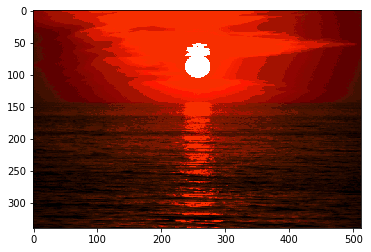

In [13]:
dst = random_quantize(rgb,32)
plt.imshow(dst)

In [14]:
def kmeans_quantize( raster, n_colors, **kwargs):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))
    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_
    quantized_raster = recreate_image(palette, labels, width, height)
    return quantized_raster

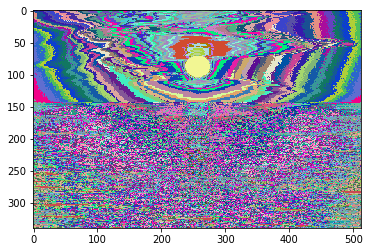

In [16]:
dst = kmeans_quantize(rgb,128)
plt.imshow(dst)

In [17]:
def rgb2yiq(imRGB):
    """
    Returns the input picture converted to yiq color scheme
    :param imRGB: The input picture to be converted
    :return: A converted picture with yiq color scheme
    """
    temp = np.dot(imRGB, yiq_from_rgb.T.copy())
    return temp


def yiq2rgb(imYIQ):
    """
    Returns the input picture converted to rgb color scheme
    :param imYIQ: The input picture to be converted
    :return: A converted picture with rgb color scheme
    """
    return np.dot(imYIQ, np.linalg.inv(yiq_from_rgb).T.copy())


def strech_helper(image, hist):
    """
    A helper function for stretching the image
    :param image: The input picture to be stretched
    :param hist: The histogram of the input image
    :return: The stretched image
    """
    image = (image * 255).astype(int)
    cdf = np.cumsum(hist)
    cdf = 255 * cdf / cdf[-1]
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    return (cdf_m[image] / 255).astype(np.float64)


def max_range_finder(z_arr):
    """
    Finds the maximal range of a certain z array representing the borders of
    the equalized histogram
    :param z_arr: An array with numbers representing borders for a histogram
    :return: The maximal range of the array as int
    """
    temp_max = 0
    for i in range(len(z_arr) - 1):
        if z_arr[i + 1] - z_arr[i] > temp_max:
            temp_max = z_arr[i + 1] - z_arr[i]
    return temp_max


def quantize_helper(hist_orig, n_quant, n_iter, z_arr=False):
    """
    Calculates the borders and gravity point for each bucket in between borders, and
    returns the minimized error, q array and z array
    :param hist_orig: The histogram of the picture to be optimized
    :param n_quant: The number of different gravity points
    :param n_iter: The number of iterations for the optimization
    :return: the error of the optimization, the qi gravity point array and the
    zi borders array.
    """
    # initializing variables
    err_arr = np.array([])

    if z_arr is False:
        z_arr = np.arange(0, 255, 255/n_quant).astype(int)
        z_arr = np.append(z_arr, 255)
    # initializing qi list used for convergence check
    old_q = np.zeros(shape=(n_quant,), dtype=int)
    temp_q = np.zeros(shape=(n_quant,), dtype=int)
    error = 0

    for i in range(n_iter):
        temp_q = np.zeros(shape=(n_quant,), dtype=int)
        for j in range(n_quant):
            temp_weights = np.array(range(z_arr[j], z_arr[j + 1]))
            temp_hist = hist_orig[z_arr[j]:z_arr[j + 1]]
            # getting the average for the current bucket
            temp_q[j] = np.average(temp_weights, weights=temp_hist, returned=False).round()

        # updating z_arr values based on the formula
        for i in range(1, len(temp_q)):
            z_arr[i] = (temp_q[i - 1] + temp_q[i]) / 2

        # checking if the old q is same. if so, we converged and can break
        if not np.array_equal(old_q, temp_q):
            old_q = temp_q
        else:
            # arrays are equal, converged
            break

        # calculating the error based on current iteration
        for m in range(len(temp_q)):
            # m is iterating through current iterations' averages
            for k in range(z_arr[m], z_arr[m + 1]):
                # k is iterating through intensities of current iteration
                temp_diff = math.pow(temp_q[m] - k, 2)
                error += temp_diff * hist_orig[k]
        err_arr = np.append(err_arr, error)
        error = 0

    return [err_arr, temp_q, z_arr]


def histogram_equalize(im_orig):
    """
    :param im_orig: The input picture to be stretched
    :return: Return values are in the format [im_eq, hist_orig, hist_eq] such that:
            :param im_eq: The equalized picture after a stretch
            :param hist_orig: The original's im_eq histogram
            :param hist_eq: The picture's histogram after the stretch
    """
    if len(im_orig.shape) == 3:
        # rgb picture, converting to yiq
        yiqTemp = rgb2yiq(im_orig)
        # isolating Y component
        [Y, I, Q] = np.dsplit(yiqTemp, yiqTemp.shape[2])
        hist_orig = np.histogram(Y, 256)[0]
        # helper function to stretch the picture's gray values
        y_eq = strech_helper(Y, hist_orig)

        # y_eq = np.clip(y_eq, 0, 1)

        # converting back to rgb
        eq_hist = np.histogram(y_eq, 256)[0]
        temp = np.concatenate((y_eq, I, Q), axis=2)
        im_eq = yiq2rgb(temp)
    else:
        # grayscale picture
        hist_orig = np.histogram(im_orig, 256)
        im_eq = strech_helper(im_orig, hist_orig[0])
        eq_hist = np.histogram(im_eq)[0]
    return [im_eq, hist_orig, eq_hist]


def quantize(im_orig, n_quant, n_iter):
    """
    A method for converting a picture to a quantize color scheme
    :param im_orig: The original picture to be quantize
    :param n_quant: The number of different colors the picture will be appeared with
    :param n_iter: The number of iterations for finding optimum quantize intensities
    :return: The quantized picture based on input values
    """
    # initializing variables
    z_arr = np.arange(0, 255, 255/n_quant).astype(int)
    z_arr = np.append(z_arr, 255)
    isRgb = False

    # checking if rgb or grayscale
    if len(im_orig.shape) == 3:
        # rgb
        isRgb = True
        yiqTemp = rgb2yiq(im_orig)
        # splitting the yiq components of the picture to handle separably
        [Y, I, Q] = np.dsplit(yiqTemp, yiqTemp.shape[2])
        hist_orig = np.histogram(Y, 256)[0]
    else:
        # grayscale
        hist_orig = np.histogram(im_orig, 256)[0]

    # calling the helper function that calculates and return the equalized qi and zi and their error
    error, temp_q, z_arr = quantize_helper(hist_orig, n_quant, n_iter)

    # assigning new values
    for i in range(n_quant):
        for j in range(z_arr[i], z_arr[i+1]+1):
            hist_orig[j] = temp_q[i]
    # checking for correct color scheme and reassembling
    if isRgb is True:
        Y = Y * 255
        Y = Y.astype(int)
        new_pic = hist_orig[Y]
        new_pic = new_pic.astype(np.float64)
        new_pic /= 255
        new_pic = yiq2rgb(np.concatenate((new_pic, I, Q), axis=2))
    else:
        im_orig = im_orig * 255
        im_orig = im_orig.astype(int)
        new_pic = hist_orig[im_orig]
        new_pic = new_pic.astype(np.float64)
        new_pic /= 255

    return [new_pic, error]


def quantize_rgb(im_orig, n_quant, n_iter):
    """
    A method for converting a colored picture to a quantize color scheme
    :param im_orig: The original colored picture to be quantize
    :param n_quant: The number of different colors the picture will be appeared with
    :param n_iter: The number of iterations for finding optimum quantize intensities
    :return: The quantized picture based on input values
    """
    final_error = 0
    if len(im_orig.shape) != 3:
        # error. we assume a colored picture
        return [-1, im_orig]

    [R, G, B] = np.dsplit(im_orig, im_orig.shape[2])
    red_hist = np.histogram(R, 256)[0]
    green_hist = np.histogram(G, 256)[0]
    blue_hist = np.histogram(B, 256)[0]

    # calculating the optimal borders and gravity points for each color
    red_err, red_q, red_z = quantize_helper(red_hist, n_quant, n_iter)
    green_err, green_q, green_z = quantize_helper(green_hist, n_quant, n_iter)
    blue_err, blue_q, blue_z = quantize_helper(blue_hist, n_quant, n_iter)
    # finding the maxmimal range of any given bucket of any given color
    red_max_range = max_range_finder(red_z)
    green_max_range = max_range_finder(green_z)
    blue_max_range = max_range_finder(blue_z)

    if red_max_range >= green_max_range and red_max_range >= blue_max_range:
        # red has max range
        # assigning new values
        final_red = quantize_apply(R, red_hist, red_q, red_z, n_quant)
        # using the z borders of the color with the highest range, applying to the rest of colors
        green_err_u, green_q_u, green_z_u = quantize_helper(green_hist, n_quant, 1, red_z)
        blue_err_u, blue_q_u, blue_z_u = quantize_helper(blue_hist, n_quant, 1, red_z)
        # applying the updated values of the other colors to create the final color array for each color
        final_green = quantize_apply(G, green_hist, green_q_u, green_z_u, n_quant)
        final_blue = quantize_apply(B, blue_hist, blue_q_u, blue_z_u, n_quant)

        final_error = red_err + green_err_u + blue_err_u
    else:
        if green_max_range >= red_max_range and green_max_range >= blue_max_range:
            final_green = quantize_apply(G, green_hist, green_q, green_z, n_quant)
            red_err_u, red_q_u, red_z_u = quantize_helper(red_hist, n_quant, 1, green_z)
            blue_err_u, blue_q_u, blue_z_u = quantize_helper(blue_hist, n_quant, 1, green_z)
            final_red = quantize_apply(R, red_hist, red_q_u, red_z_u, n_quant)
            final_blue = quantize_apply(B, blue_hist, blue_q_u, blue_z_u, n_quant)

            final_error = green_err + red_err_u + blue_err_u
        else:
            if blue_max_range >= red_max_range and blue_max_range >= green_max_range:
                final_blue = quantize_apply(B, blue_hist, blue_q, blue_z, n_quant)
                red_err_u, red_q_u, red_z_u = quantize_helper(red_hist, n_quant, 1, blue_z)
                green_err_u, green_q_u, green_z_u = quantize_helper(green_hist, n_quant, 1, blue_z)
                final_green = quantize_apply(G, green_hist, green_q_u, green_z_u, n_quant)
                final_red = quantize_apply(R, red_hist, red_q_u, red_z_u, n_quant)

                final_error = blue_err + green_err_u + red_err_u

    # merging all the colors to a new equalized picture
    eq_pic = np.concatenate((final_red, final_green, final_blue), axis=2)

    return [eq_pic, final_error]


def quantize_apply(color_arr, hist_orig, q_arr, z_arr, n_quant):
    """
    Applying the new color table using it's histogram and the corresponding q and z arrays
    :param color_arr: The color array to be updated
    :param hist_orig: The picture's histogram
    :param q_arr: Q array indicating the gravity points for each segment
    :param z_arr: Z array indicating the border lines for each segment
    :param n_quant: the number of different colors to be mapped
    :return: The updated color array with quantized values
    """
    for i in range(n_quant):
        for j in range(z_arr[i], z_arr[i + 1] + 1):
            hist_orig[j] = q_arr[i]
    # converting the color array and mapping the quantized values based on the look up table
    color_arr = color_arr * 255
    color_arr = color_arr.astype(int)
    updated_color_arr = hist_orig[color_arr]
    updated_color_arr = updated_color_arr.astype(np.float64)
    updated_color_arr /= 255

    return updated_color_arr